In [177]:
from sklearn.model_selection import cross_val_predict, cross_val_score,GridSearchCV
import sklearn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import norm 
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import metrics
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import skew
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold
from sklearn.metrics import mean_squared_log_error

In [98]:
os.chdir('C:/Users/Gary/Documents/Python Scripts/House prices')

In [99]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [100]:
train_rowsize = train.shape[0]
test_rowsize = test.shape[0]
test_id=test["Id"]
y=train['SalePrice']

In [101]:
data_all = pd.concat((train.loc[:, train.columns != 'SalePrice'], test),sort=False)

In [102]:
data_all = data_all.drop(['Id',"BsmtFinSF2",'GarageArea','TotalBsmtSF','GarageYrBlt','TotRmsAbvGrd','YearRemodAdd','MasVnrArea','LotFrontage','BsmtFinSF1','BsmtFullBath'],axis=1)
data_all = data_all.drop(["Fence","MiscFeature","Alley","PoolQC","2ndFlrSF"],axis=1)

## Replacing missing values

In [103]:
data_all.MasVnrType.fillna("None", inplace = True) 
data_all.BsmtQual.fillna("NA", inplace = True) 
data_all.BsmtCond.fillna("NA", inplace = True)
data_all.BsmtExposure.fillna("NA", inplace = True)
data_all.BsmtFinType1.fillna("NA", inplace = True)
data_all.BsmtFinType2.fillna("NA", inplace = True)
data_all.Electrical.fillna("SBrkr", inplace = True)
data_all.FireplaceQu.fillna("NA", inplace = True)
data_all.GarageType.fillna("NA", inplace = True)
data_all.GarageFinish.fillna("NA", inplace = True)
data_all.GarageQual.fillna("NA", inplace = True)
data_all.GarageCond.fillna("NA", inplace = True)
data_all.SaleType.fillna("Other", inplace = True)
data_all.GarageCars.fillna(0, inplace = True)
data_all.Utilities.fillna("AllPub",inplace=True)
data_all.MSZoning.fillna("RL",inplace=True)
data_all.BsmtHalfBath.fillna(0,inplace=True)
data_all.Functional.fillna("Functional",inplace=True)
data_all.KitchenQual.fillna("TA",inplace=True)
data_all.BsmtUnfSF.fillna(0,inplace=True)
data_all.Exterior1st.fillna(data_all.Exterior1st.value_counts().index[0], inplace=True)
data_all.Exterior2nd.fillna(data_all.Exterior2nd.value_counts().index[0], inplace=True)

data_all.isnull().sum().sum()

0

## Encoding

In [104]:
import category_encoders as ce
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [105]:
# Give an order to variables with Cond or Qual in the name
ordinal = [c for c in data_all.columns
           if "Condition" not in c and data_all[c].dtypes != "int64" and
           ("Cond" in c or
           "Qual" in c)]

In [106]:
cat_type = CategoricalDtype(categories=["NA", "Po", "Fa", "TA", "Gd", "Ex"],
                            ordered=True)

for var in ordinal:
    data_all[var] = data_all[var].astype(cat_type)

# Encode the ordinal variables
encoder = ce.ordinal.OrdinalEncoder(verbose=1, cols=ordinal)
data_all = encoder.fit_transform(data_all)


In [107]:
list_int = []
list_float = []
list_cat = []

for x in data_all.columns:
    if data_all[x].dtypes == "int64" or data_all[x].dtypes == "int32":
        list_int.append(x)
    elif data_all[x].dtypes == "float64":
        list_float.append(x)
    elif data_all[x].dtypes == "O":
        list_cat.append(x)

In [108]:
 data_all=pd.get_dummies(data_all)

In [109]:
train_new = data_all[:train_rowsize]
test_new = data_all[train_rowsize:]

In [110]:
y = train.loc[:, train.columns == 'SalePrice']
df = train_new
df_test = test_new

In [111]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [31]:
categorical_features=['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities',
                      'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
                      'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond',
                      'Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating',
                      'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
                     'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition']
every_column_non_categorical= [col for col in train.columns if col not in categorical_features and col not in ['Id'] ]
numeric_feats = train[every_column_non_categorical].dtypes[train.dtypes != "object"].index
train[numeric_feats] = np.log1p(train[numeric_feats])

In [32]:
every_column_non_categorical= [col for col in test.columns if col not in categorical_features and col not in ['Id'] ]
numeric_feats = test[every_column_non_categorical].dtypes[test.dtypes != "object"].index
test[numeric_feats] = np.log1p(test[numeric_feats])

In [34]:
train = pd.get_dummies(train,columns =categorical_features)
test = pd.get_dummies(test,columns =categorical_features)

In [38]:
# training dataset
df = train.loc[:, train.columns != 'SalePrice']
y = train.loc[:, train.columns == 'SalePrice']

In [10]:
corrmat = train.corr() 
cols = corrmat.nlargest(20, 'SalePrice')['SalePrice'].index
cols=cols[1:]

In [11]:
y = train.loc[:, train.columns == 'SalePrice']
df = train[cols]
df_test = test[cols]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

## Linear regression

In [115]:
# fit a model
from sklearn import datasets, linear_model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
real_prediction = lm.predict(df_test)

In [117]:
mean_squared_log_error(y_test, abs(predictions))

0.08060019708469293

Text(0, 0.5, 'Predictions')

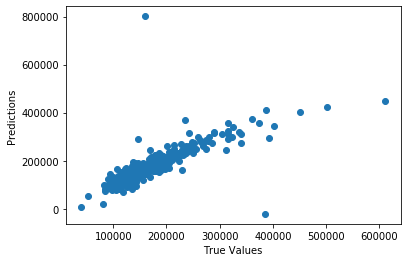

In [116]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

## Ridge regression

In [ ]:
# Very good analyssi including overfitting considerations
#https://www.kaggle.com/laurenstc/top-2-of-leaderboard-advanced-fe 

In [232]:

#Build our cross validation method
kfolds = KFold(n_splits=10, shuffle=True, random_state=23)

#build our model scoring function
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)


#second scoring metric
def cv_rmsle(model):
    rmsle = np.sqrt(np.log(-cross_val_score(model, X_train, y_train,
                                           scoring = 'neg_mean_squared_error',
                                           cv=kfolds)))
    return(rmsle)

In [234]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
def ridge_selector(k):
    ridge_model = make_pipeline(RobustScaler(),
                                RidgeCV(alphas = [k],
                                        cv=kfolds)).fit(X_train, y_train)
    
    ridge_rmse = cv_rmse(ridge_model).mean()
    return(ridge_rmse)

In [235]:
r_alphas = [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)

,RMSE
0.0001,30711.681812
0.0003,30710.983593
0.0005,30710.286201
0.0007,30709.589635
0.0009,30708.893893
0.0100,30678.082643
0.0500,30559.535224
0.1000,30440.784329
0.3000,30141.514853
1.0000,29728.734310


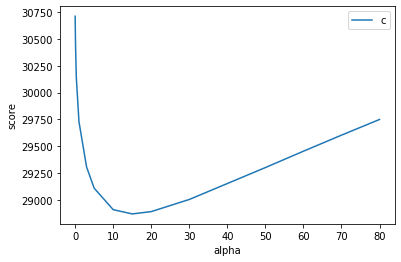

In [236]:
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

ridge_score_table = pd.DataFrame(ridge_scores, r_alphas, columns=['RMSE'])
ridge_score_table

## Lasso

In [ ]:
from sklearn.linear_model import LassoCV


alphas = [0.00005, 0.0001, 0.0003, 0.0005, 0.0007, 
          0.0009, 0.01]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]


lasso_model2 = make_pipeline(RobustScaler(),
                             LassoCV(max_iter=1e7,
                                    alphas = alphas2,
                                    random_state = 42)).fit(X_train, y_train.values.ravel())

In [ ]:
scores = lasso_model2.steps[1][1].mse_path_

plt.plot(alphas2, scores, label='Lasso')
plt.legend(loc='center')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

## Decision Trees

In [118]:
from sklearn.tree import DecisionTreeRegressor


In [120]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=10)
regr_4 = DecisionTreeRegressor(max_depth=15)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)
regr_3.fit(X_train, y_train)
regr_4.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [121]:
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)
y_4 = regr_4.predict(X_test)
real_prediction = regr_4.predict(df_test)

(292, 1)

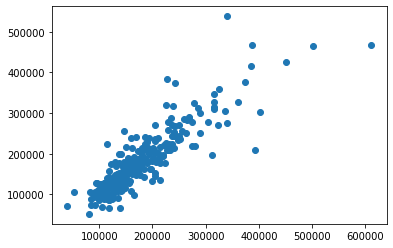

In [126]:
plt.scatter(y_test, y_4)
#plt.xlabel('True Values')
#plt.ylabel('Predictions')
y_test.shape

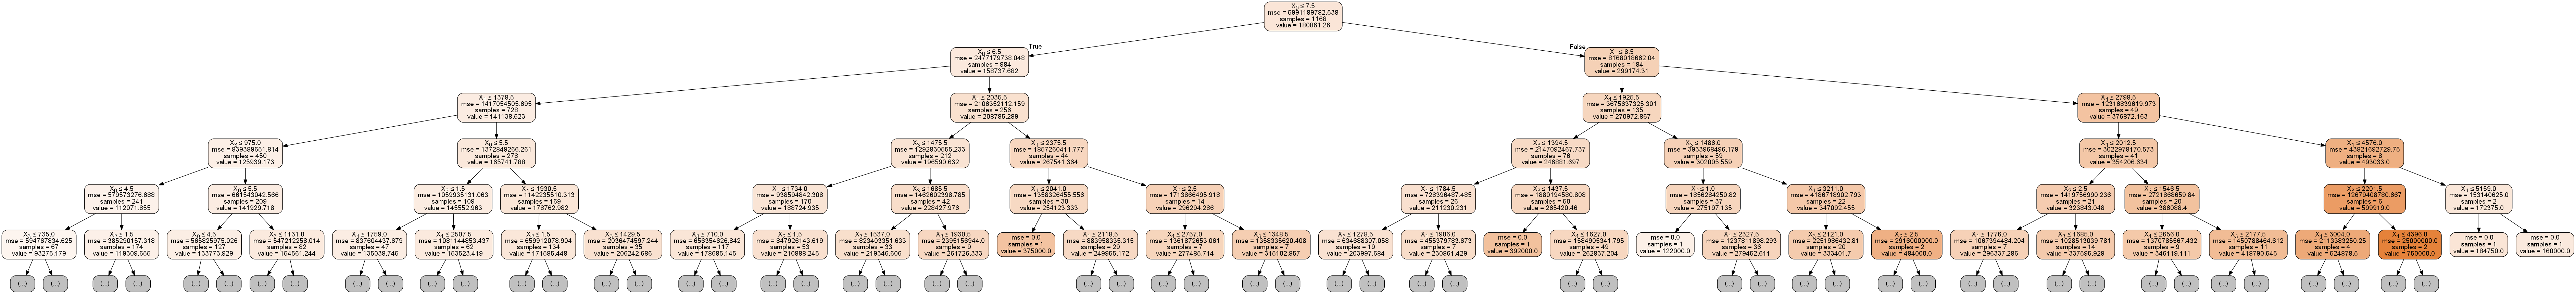

In [78]:
#visualizing decision tree
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(regr_4, out_file=dot_data, max_depth=5,
filled=True, rounded=True,
special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# Support Vector Machine

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
#clf.fit(X_train, y_train.values.ravel())
clf.fit(X_train, y_train.values.ravel())

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
real_prediction = clf.predict(df_test)

In [ ]:
plt.scatter(y_test, y_pred)
#plt.xlabel('True Values')
#plt.ylabel('Predictions')
y_test.shape

# XGBoost

In [ ]:
https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
https://www.kaggle.com/pablocastilla/predict-house-prices-with-xgboost-regression

In [37]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [47]:
model.fit(df,y)
OrderedDict(sorted(model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

In [50]:
#Let's remove the less important ones 
most_relevant_features= list( dict((k, v) for k, v in model.get_booster().get_fscore().items() if v >= 10).keys())

In [52]:
#removing outliers
train_dataset = train[train.GrLivArea < 8.25]
train_dataset = train[train.LotArea < 11.5]
train_dataset = train[train.SalePrice<13]
train_dataset = train[train.SalePrice>10.75]

In [54]:
train_x=train_dataset[most_relevant_features]
train_y=train_dataset['SalePrice']

In [185]:
#for tuning parameters
parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    'n_estimators':[10000],
    'reg_alpha':[ 0.75],
    'reg_lambda':[ 0.45],
    'subsample':[0.95]  
}

                    
#xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
#     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

#gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
#gsearch1.fit(train_x,train_y)
#print (gsearch1.grid_scores_)
#print('best params')
#print (gsearch1.best_params_)
#print('best score')
#print (gsearch1.best_score_)


In [187]:
from xgboost import XGBRegressor

In [189]:
best_xgb_model = XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

best_xgb_model.fit(X_train,y_train)

[22:41:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None,
             n_estimators=10000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, silent=None, subsample=0.6,
             verbosity=1)

In [190]:
modelfit(best_xgb_model, X_train, y_train,X_test,y_test,printFeatureImportance=False)

[22:43:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:45:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:47:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:52:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Ac

In [191]:
best_xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
best_xgboost.fit(X_train,y_train)


[22:53:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=None, n_estimators=3460,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.7, verbosity=1)

In [194]:
modelfit(best_xgboost, X_train, y_train,X_test,y_test,printFeatureImportance=False,cv_folds=3)

[22:55:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:57:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:57:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Accuracy : 0.003481
With test : 0.01493
CV Score : Mean - 0.8790793 | Std - 0.04841839 | Min - 0.8109918 | Max - 0.9194146


In [200]:
real_prediction = best_xgboost.predict(df_test)
#filename = 'submission.csv'
#pd.DataFrame({'Id': test.Id, 'SalePrice': test.Prediction}).to_csv(filename, index=False)

In [201]:
my_submission = pd.DataFrame({'Id': test['Id'], 'SalePrice':real_prediction})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_xgboost2.csv', index=False)

In [199]:
real_prediction

array([inf, inf, inf, ..., inf, inf, inf], dtype=float32)

## Random Forest

In [40]:
# Initialize the model
random_forest = RandomForestRegressor(n_estimators=1200,
                                      max_depth=15,
                                      min_samples_split=5,
                                      min_samples_leaf=5,
                                      max_features=None,
                                      random_state=42,
                                      oob_score=True
                                     )

# Perform cross-validation to see how well our model does 
kf = KFold(n_splits=5)
y_pred = cross_val_score(random_forest, X_train, y_train, cv=kf, n_jobs=-1)
y_pred.mean()

0.8257972079277571

In [41]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [61]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train, y_train)

In [81]:
import numpy as np
rf_random.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 19.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [85]:
dir(rf_random)
pred=rf_random.predict(X_test)

In [86]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error( y_test, pred ))

0.14175477837718384

In [87]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error( y_train, rf_random.predict(X_train) ))

0.05658024549127659

In [84]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [ ]:
mean_squared_log_error(y_true, y_pred)

In [89]:
y_pred = cross_val_predict(random_forest, X_train, y_train, cv=kf, n_jobs=-1)


In [88]:
y_pred.shape

(5,)

## Gradient boost regressor

In [ ]:
https://rcarneva.github.io/understanding-gradient-boosting-part-1.html
https://github.com/aarshayj/analytics_vidhya/blob/master/Articles/Parameter_Tuning_GBM_with_Example/GBM%20model.ipynb

In [129]:
def modelfit(alg, dX_train,  dy_train, dX_test, dy_test,predictors,  performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dX_train, dy_train.values.ravel())
        
    #Predict training set:
    dtrain_predictions = alg.predict(dX_train)
    dtest_predictions = alg.predict(dX_test)
#    dtrain_predprob = alg.predict_proba(dX_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dX_train, dy_train.values.ravel(), cv=cv_folds)
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % mean_squared_log_error(dy_train, dtrain_predictions))
    print ("With test : %.4g" % mean_squared_log_error(dy_test, dtest_predictions))
#    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dy_train, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.008366
With test : 0.01857
CV Score : Mean - 0.8674659 | Std - 0.07425596 | Min - 0.719678 | Max - 0.9160441


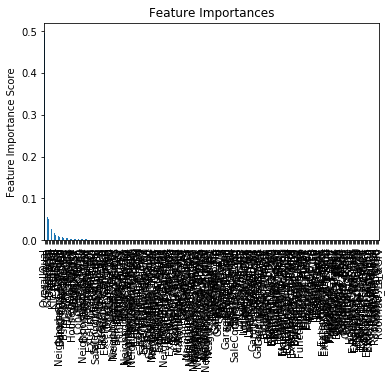

In [134]:
gbm0 = GradientBoostingRegressor(random_state=10)
predictors = [x for x in X_train.columns]
modelfit(gbm0, X_train, y_train,X_test, y_test, predictors)

GBM Models:
There 2 types of parameters here:

Tree-specific parameters
    min_samples_split
    min_samples_leaf
    max_depth
    min_leaf_nodes
    max_features
    loss function
Boosting specific paramters
    n_estimators
    learning_rate
    subsample
Approach for tackling the problem
1. Decide a relatively higher value for learning rate and tune the number of estimators requried for that.
2. Tune the tree specific parameters for that learning rate
3. Tune subsample
4. Lower learning rate as much as possible computationally and increase the number of estimators accordingly.

Step 1- Find the number of estimators for a high learning rate
We will use the following benchmarks for parameters:

min_samples_split = 15 : ~0.5-1% of total values. Since this is imbalanced class problem, we'll take small value

min_samples_leaf = 50 : Just using for preventing overfitting. will be tuned later.

max_depth = 8 : since high number of observations and predictors, choose relatively high value

max_features = 'sqrt' : general thumbrule to start with

subsample = 0.8 : typically used value (will be tuned later)

0.1 is assumed to be a good learning rate to start with. Let's try to find the optimum number of estimators requried for this.

With learning rate 0.1, the number of estimators always increases. Therefore, we will increase the learning rate to 0.2.

In [139]:
predictors = [x for x in X_train.columns]
param_test1 = {'n_estimators':range(20,201,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.3, min_samples_split=15,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1,n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.3,
                                                 loss='ls', max_depth=8,
                                                 max_features='sqrt',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=50,
                                                 min_samples_split=15,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
            

1. If the value is around 20, you might want to try lowering the learning rate to 0.05 and re-run grid search
2. If the values are too high ~100, tuning the other parameters will take long time and you can try a higher learning rate


In [140]:
gsearch1.best_estimator_

# the best esimator is n_estimators=120 when the learning rate is 0.3

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='ls', max_depth=8,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=50, min_samples_split=15,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Step 2- Tune tree-specific parameters
Now, lets move onto tuning the tree parameters. We will do this in 2 stages:

Tune max_depth and num_samples_split

Tune min_samples_leaf

Tune max_features

In [141]:
#Grid seach on subsample and max_features
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.3, n_estimators=120,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2,n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.3,
                                                 loss='ls', max_depth=3,
                                                 max_features='sqrt',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=120,
                                                 n_iter_no_change=None,
              

In [143]:
gsearch2.best_estimator_
# in optimum we have min_samples_split=600 and max_depth =5

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='ls', max_depth=5,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=600,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [144]:
param_test3 = {'min_samples_leaf':range(1,71,10),'max_features':range(7,20,2)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.3, n_estimators=80,max_depth=7,
                                                     subsample=0.8, random_state=10,min_samples_split=600), 
                       param_grid = param_test3,n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.3,
                                                 loss='ls', max_depth=7,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=600,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=80,
                                                 n_iter_no_change=None,
               

In [145]:
gsearch3.best_estimator_
#gsearch3.cv_results_

# in optimum we have max_features =19 but the min_samples_leaf =21

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='ls', max_depth=7,
                          max_features=19, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=600,
                          min_weight_fraction_leaf=0.0, n_estimators=80,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [149]:
param_test4 = {'max_depth':range(2,16,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.3, n_estimators=120,
                                                max_features =19, min_samples_leaf =21,min_samples_split=600,
                                                              subsample=0.8, random_state=10), 
                       param_grid = param_test4,n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.3,
                                                 loss='ls', max_depth=3,
                                                 max_features=19,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=21,
                                                 min_samples_split=600,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=120,
                                                 n_iter_no_change=None,
               

In [150]:
gsearch4.best_estimator_
#gsearch3.cv_results_

# in optimum we have max_features =19 but the min_samples_leaf =21

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='ls', max_depth=6,
                          max_features=19, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=600,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Step3 - Tune Subsample and Lower Learning Rate

In [153]:
#Grid seach on subsample and max_features
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9,0.95]}
g_boost=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='ls', max_depth=6,
                          max_features=19, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=600,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
gsearch5 = GridSearchCV(estimator = g_boost,
                       param_grid = param_test5,n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.3,
                                                 loss='ls', max_depth=6,
                                                 max_features=19,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=21,
                                                 min_samples_split=600,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=120,
                                                 n_iter_no_change=None,
               

In [154]:
gsearch5.best_estimator_

# Optimal subsample is 8


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='ls', max_depth=6,
                          max_features=19, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=600,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=0.95, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

With all tuned lets try reducing the learning rate and proportionally increasing the number of estimators to get more robust results:




Model Report
Accuracy : 0.01212
With test : 0.0216
CV Score : Mean - 0.8719337 | Std - 0.02863408 | Min - 0.8173255 | Max - 0.9011902


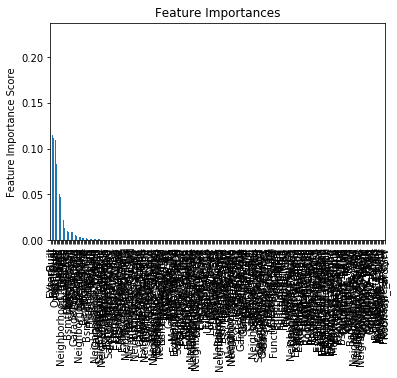

In [155]:
gbm_tuned_1=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='ls', max_depth=6,
                          max_features=19, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=600,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=0.95, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

modelfit(gbm_tuned_1, X_train, y_train,X_test,y_test)


Model Report
Accuracy : 0.01065
With test : 0.01975
CV Score : Mean - 0.8749802 | Std - 0.03359814 | Min - 0.815459 | Max - 0.9196707


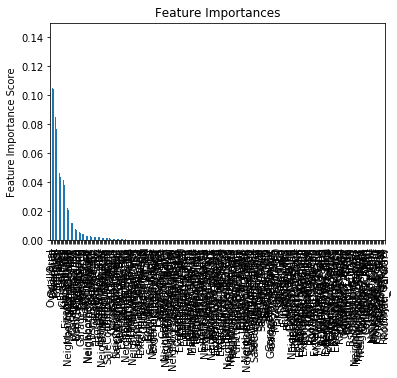

In [156]:
gbm_tuned_2=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=19, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=600,
                          min_weight_fraction_leaf=0.0, n_estimators=360,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=0.95, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

modelfit(gbm_tuned_2, X_train, y_train,X_test,y_test)


Model Report
Accuracy : 0.0104
With test : 0.01992
CV Score : Mean - 0.8780453 | Std - 0.03621601 | Min - 0.8112898 | Max - 0.9196195


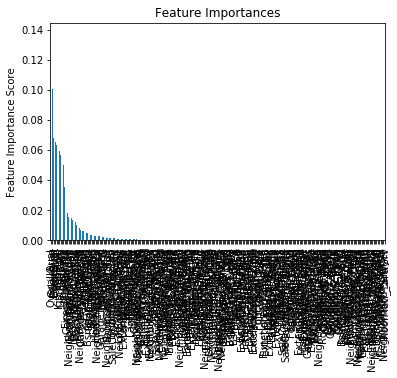

In [157]:
gbm_tuned_3=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=6,
                          max_features=19, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=600,
                          min_weight_fraction_leaf=0.0, n_estimators=720,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=0.95, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

modelfit(gbm_tuned_3, X_train, y_train,X_test,y_test)


Model Report
Accuracy : 0.0102
With test : 0.01946
CV Score : Mean - 0.8792424 | Std - 0.03204798 | Min - 0.8200863 | Max - 0.9169429


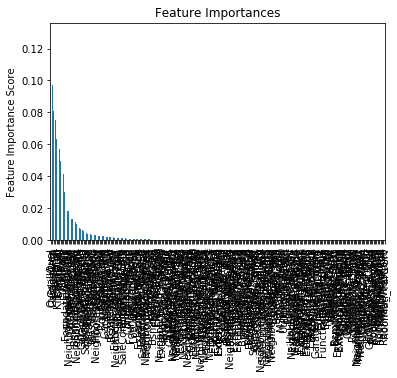

In [158]:
gbm_tuned_3=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=6,
                          max_features=19, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=600,
                          min_weight_fraction_leaf=0.0, n_estimators=3600,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=0.95, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

modelfit(gbm_tuned_3, X_train, y_train,X_test,y_test)

In [213]:
gbm_tuned_3.fit(X_train,y_train.values.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=6,
                          max_features=19, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=600,
                          min_weight_fraction_leaf=0.0, n_estimators=3600,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=0.95, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [161]:
pd.Series(gbm_tuned_3.feature_importances_, predictors).sort_values(ascending=False)

OverallQual              0.129662
GrLivArea                0.097355
GarageCars               0.080569
1stFlrSF                 0.075023
ExterQual                0.063397
KitchenQual              0.059362
BsmtQual                 0.057321
YearBuilt                0.049784
FullBath                 0.047636
LotArea                  0.041582
Fireplaces               0.030047
Foundation_PConc         0.024163
FireplaceQu_NA           0.018394
Neighborhood_NoRidge     0.018323
GarageFinish_Fin         0.016878
OpenPorchSF              0.013356
WoodDeckSF               0.013272
BsmtFinType1_GLQ         0.011483
BsmtExposure_Gd          0.011119
Neighborhood_NridgHt     0.009915
HeatingQC_Ex             0.009781
HalfBath                 0.007494
OverallCond              0.006747
GarageType_Detchd        0.006105
GarageFinish_Unf         0.005733
MasVnrType_None          0.005415
SaleCondition_Partial    0.004515
BedroomAbvGr             0.003960
GarageType_Attchd        0.003696
BsmtUnfSF     


Model Report
Accuracy : 0.0134
With test : 0.01913
CV Score : Mean - 0.8541796 | Std - 0.03157429 | Min - 0.806937 | Max - 0.8896399


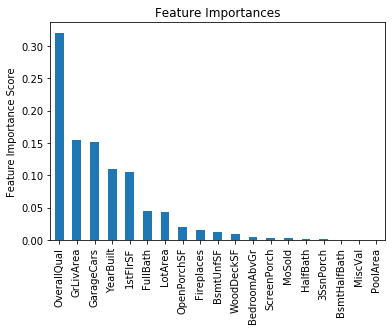

In [218]:
gbm_tuned_1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=240,max_depth=7, min_samples_split=400, 
                                         min_samples_leaf=11, subsample=0.8, random_state=10, max_features=7)
modelfit(gbm_tuned_1, X_train, y_train,X_test,y_test)


Model Report
Accuracy : 0.01335
With test : 0.01829
CV Score : Mean - 0.8560729 | Std - 0.03189037 | Min - 0.8118349 | Max - 0.8976959


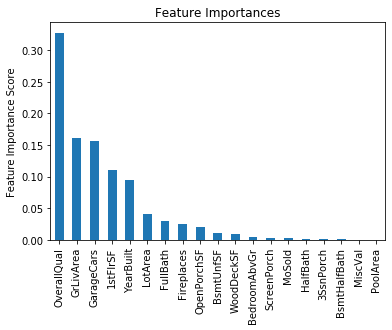

In [220]:
gbm_tuned_1 = GradientBoostingRegressor(learning_rate=0.01, n_estimators=2400,max_depth=7, min_samples_split=400, 
                                         min_samples_leaf=11, subsample=0.8, random_state=10, max_features=7)
modelfit(gbm_tuned_1, X_train, y_train,X_test,y_test)


Model Report
Accuracy : 0.01319
With test : 0.01853
CV Score : Mean - 0.8562411 | Std - 0.0311693 | Min - 0.8125175 | Max - 0.8972537


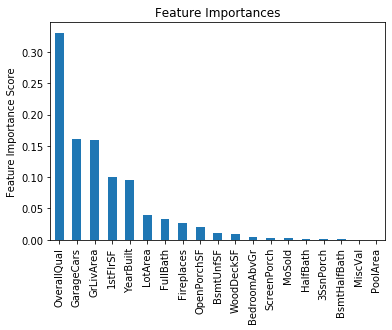

In [223]:
gbm_tuned_1 = GradientBoostingRegressor(learning_rate=0.005, n_estimators=4800,max_depth=7, min_samples_split=400, 
                                         min_samples_leaf=11, subsample=0.8, random_state=10, max_features=7)
modelfit(gbm_tuned_1, X_train, y_train,X_test,y_test)

In [224]:
# Initialize our model
g_boost = GradientBoostingRegressor(learning_rate=0.005, n_estimators=4800,max_depth=7, min_samples_split=400, 
                                         min_samples_leaf=11, subsample=0.8, random_state=10, max_features=7)

# Perform cross-validation to see how well our model does 
kf = KFold(n_splits=5)
y_pred = cross_val_score(g_boost, df, y_train, cv=kf, n_jobs=-1)
y_pred.mean()

0.8562411111749741

In [97]:
mean_squared_log_error(y_test, g_boost.predict(X_test))

0.018481855688215285

In [228]:
best_gbm_model_X_train=g_boost.fit(X_train,y_train.values.ravel())

In [231]:
best_gbm_model_train=g_boost.fit(df,y.values.ravel())

In [236]:
real_prediction_gbm_X_train=best_gbm_model_X_train.predict(df_test)
real_prediction_gbm_train=best_gbm_model_train.predict(df_test)

In [238]:
my_submission = pd.DataFrame({'Id': test['Id'], 'SalePrice':real_prediction_gbm_train})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_gbm_train.csv', index=False)

## Light GBM

Automated parameters - Bayesian optimisation of hyperparameters

https://www.codementor.io/mikekraus/using-bayesian-optimisation-to-reduce-the-time-spent-on-hyperparameter-tuning-tgc3ikmp2

https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Bayesian%20Hyperparameter%20Optimization%20of%20Gradient%20Boosting%20Machine.ipynb

Comparison of boosting alforithms
https://www.kdnuggets.com/2018/03/catboost-vs-light-gbm-vs-xgboost.html

Comparison of boosting algorithms with papers:
https://towardsdatascience.com/clearing-air-around-boosting-28452bb63f9e#2c63

In [164]:
from lightgbm import LGBMRegressor

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=6,
                                       learning_rate=0.01, 
                                       n_estimators=6400,
                                       verbose=-1,
                                       bagging_fraction=0.80,
                                       bagging_freq=4, 
                                       bagging_seed=6,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                    )

# Perform cross-validation to see how well our model does
kf = KFold(n_splits=5)
y_pred = cross_val_score(lightgbm, X_train, y_train, cv=kf)
print(y_pred.mean())

0.8797618526892371


In [170]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [173]:
best_lightgbm=lightgbm.fit(X_train,y_train)

In [172]:
modelfit(model, X_train, y_train,X_test,y_test,printFeatureImportance=False)


Model Report
Accuracy : 0.008861
With test : 0.01947
CV Score : Mean - 0.8812971 | Std - 0.04189108 | Min - 0.8005951 | Max - 0.9197276


In [174]:
real_prediction_lightgbm=best_lightgbm.predict(df_test)

In [175]:
my_submission = pd.DataFrame({'Id': test['Id'], 'SalePrice':real_prediction_lightgbm})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_lightgbm.csv', index=False)

## Stacked model

In [207]:
from mlxtend.regressor import StackingCVRegressor

In [202]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [203]:
gbr=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=6,
                          max_features=19, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=600,
                          min_weight_fraction_leaf=0.0, n_estimators=3600,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=0.95, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [204]:
xgboost=XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [208]:
stack_gen = StackingCVRegressor(regressors=(gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [211]:
stacked=stack_gen.fit(X_train,y_train.values.ravel())

[23:31:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:33:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:34:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:35:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:36:42] WARNI

In [ ]:
modelfit(stack, X_train, y_train,X_test,y_test,printFeatureImportance=False,cv_folds=3)

## Ensambled model

In [214]:
real_prediction=(0.1 * gbm_tuned_3.predict(df_test)) + \
            (0.3 * best_xgboost.predict(df_test)) + \
            (0.1 * best_lightgbm.predict(df_test)) + \
            (0.5 * stacked.predict(np.array(df_test)))

# Submission

In [215]:
my_submission = pd.DataFrame({'Id': test['Id'], 'SalePrice':real_prediction})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_stacked.csv', index=False)